In [19]:
import re
import pickle
import string
import gensim
import pandas            as pd
import matplotlib.pyplot as plt

from nltk                            import word_tokenize
from nltk.corpus                     import stopwords
from nltk.tokenize                   import TweetTokenizer
from nltk.stem.porter                import PorterStemmer
from wordcloud                       import WordCloud
from collections                     import Counter
from gensim.models                   import Word2Vec
from sklearn.manifold                import TSNE
from IPython.core.display            import HTML
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn                         import svm
from sklearn.metrics                 import f1_score
from sklearn.neighbors               import KNeighborsClassifier

In [20]:
location = './twitter_data/train2017.tsv'
df = pd.read_csv(location , sep = "\t" , header = None)

In [21]:
# ndf = df.head(10) #takes the first x entries

# dl = ndf.values.tolist()

dl = df.values.tolist()

emotions    = []
positives   = []
negatives   = []
neutrals    = []
tokens      = []
fusedTokens = []
tknzr       = TweetTokenizer(preserve_case = False, 
                             strip_handles = True, 
                             reduce_len    = True)
for item in dl:
#     print("\nITEM = ",item)
    tweet = item[3]
    emotions.append(item[2])
#     if item[2] == "positive":
#         emotions.append(1)
#     elif item[2] == "negative":
#         emotions.append(-1)
#     elif item[2] == "neutral":
#         emotions.append(0)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*' , '' , tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+' , '' , tweet)
 
    # remove hyperlinks
#     tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    
    # remove hashtags, removing the hash (#) sign only from the word
    tweet = re.sub(r'#' , '' , tweet)
    
    temp = tknzr.tokenize(tweet)
    
#     print("TEMP 1 = ",temp)
    
#     temp = [w.lower() for w in temp] #convert to lower case
    
    stop_words = stopwords.words('english')    #sets stop words
    newStopWords = ["i'm" , "he's" , "she's" , "it's" , "we're" , "you're" , "they're" , "via"]
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    
    temp = [w for w in temp if not w in stop_words]  #removes stop words
#     print("TEMP 2 = ",temp)

    table = str.maketrans('', '', string.punctuation) #remove punctuation
    temp = [w.translate(table) for w in temp]
#     print("TEMP 3 = ",temp)

    temp = [word for word in temp if word.isalpha()] #remove remaining tokens that are not alphabetic
#     print("TEMP 4 = ",temp)

#     porter = PorterStemmer() #stemming (not that useful)
#     temp = [porter.stem(word) for word in temp]

    if item[2] == "positive":  #need to give the words positive and negative weight so that the most common words in positive posts is not "tomorrow"
        positives.extend(temp)
    elif item[2] == "negative":
        negatives.extend(temp)
    elif item[2] == "neutral":
        neutrals.extend(temp)
        
    fusedTokens.extend(temp)
    tokens.append(temp)
    
# print("\n\033[1;33mPrinting Tokens\033[0m")
# for i,tok in enumerate(tokens):
#     print("\033[1;34m->\033[0m",tok)
# print("\n\033[1;33mPrinting Fuzed Tokens\033[0m")
# print(fusedTokens)

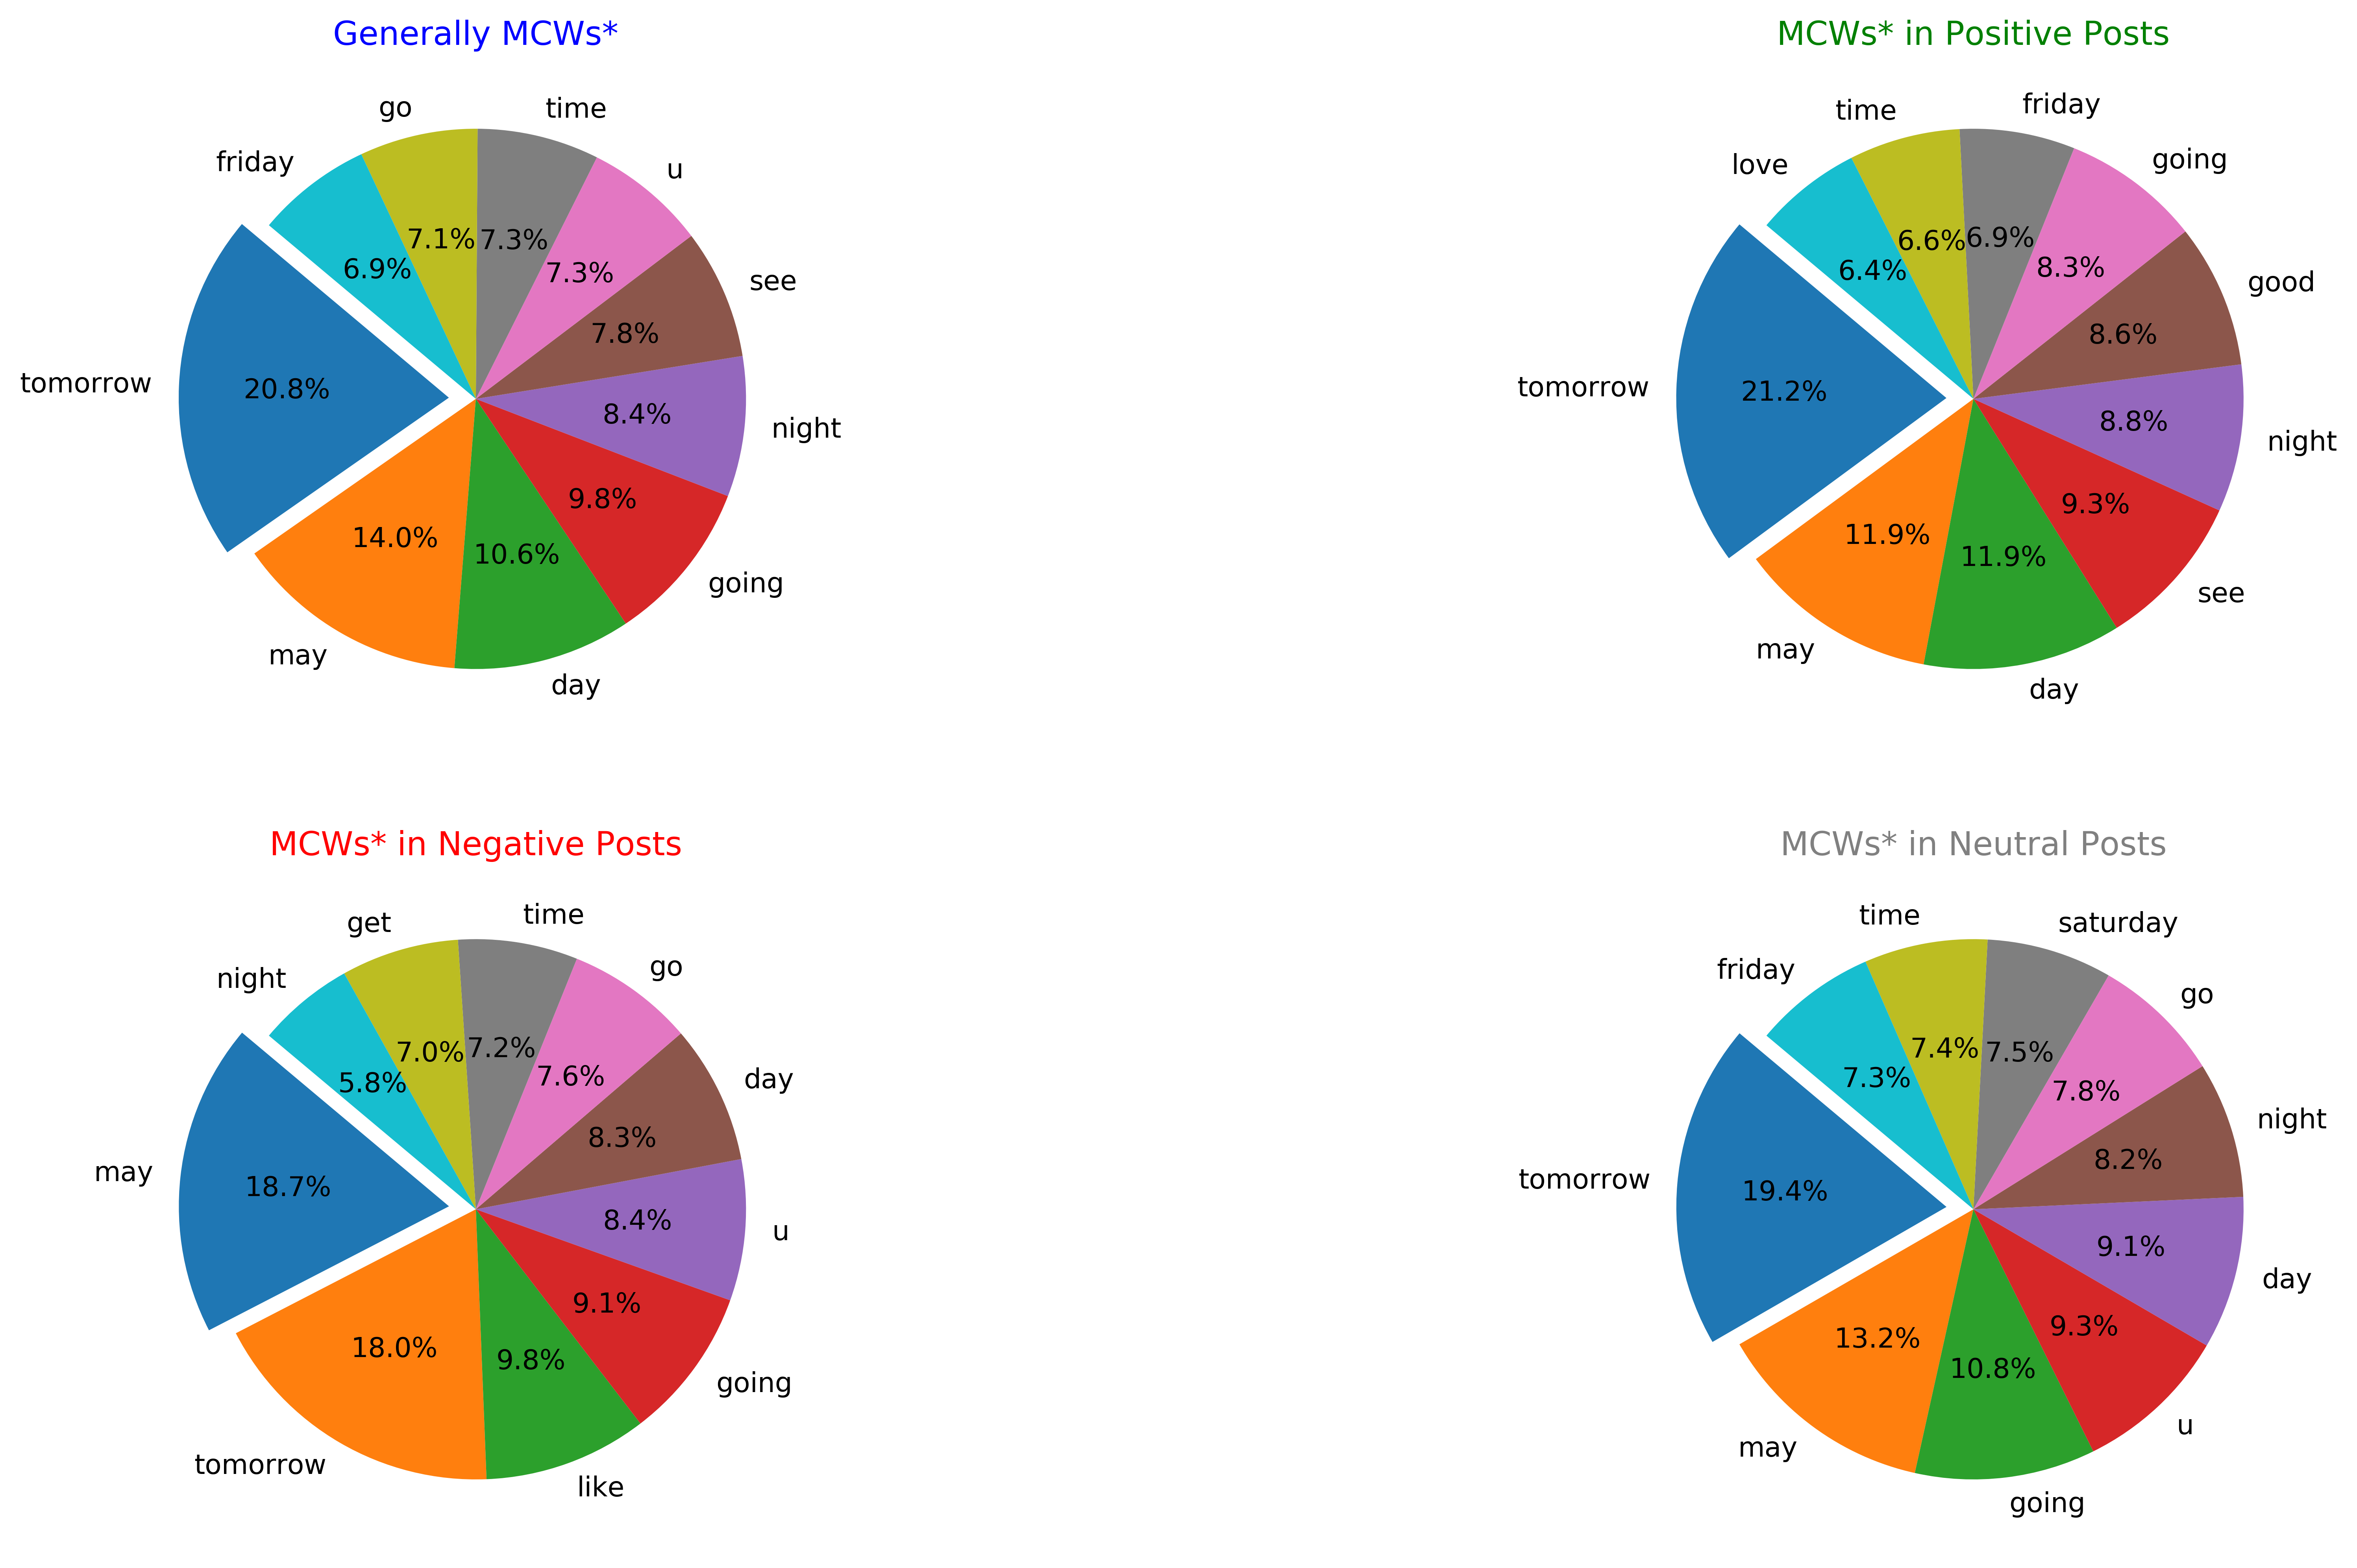

*MCW = Most Common Words


In [22]:
fz_count = Counter(fusedTokens)
# print("\033[1;33mGenerally most common words:\033[0m\n" , fz_count.most_common(10))

ps_count = Counter(positives)
# print("\033[1;33m\nMost common words found in positive posts:\033[0m\n" , ps_count.most_common(10))

ng_count = Counter(negatives)
# print("\033[1;33m\nMost common words found in negative posts:\033[0m\n" , ng_count.most_common(10))

nt_count = Counter(neutrals)
# print("\033[1;33m\nMost common words found in neutral posts:\033[0m\n" , nt_count.most_common(10))

#The data for the pie chart
fz_data   = []
fz_labels = []
for freq in fz_count.most_common(10):
    fz_labels.append(freq[0])
    fz_data.append(freq[1])

ps_data   = []
ps_labels = []
for freq in ps_count.most_common(10):
    ps_labels.append(freq[0])
    ps_data.append(freq[1])

ng_data   = []
ng_labels = []
for freq in ng_count.most_common(10):
    ng_labels.append(freq[0])
    ng_data.append(freq[1])

nt_data   = []
nt_labels = []
for freq in nt_count.most_common(10):
    nt_labels.append(freq[0])
    nt_data.append(freq[1])

# Data to plot
# labels = 'Python', 'C++', 'Ruby', 'Java'
# sizes = [215, 130, 245, 210]
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # explode 1st slice

fig = plt.figure(figsize=(18,10), dpi=500)
#2 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(fz_data, explode=explode, labels=fz_labels, autopct='%1.1f%%', startangle=140)
plt.title("Generally MCWs*", color = 'Blue')
# first row sec col
ax1 = plt.subplot2grid((2,2), (0, 1))
plt.pie(ps_data, explode=explode, labels=ps_labels, autopct='%1.1f%%', startangle=140)
plt.title("MCWs* in Positive Posts", color = 'Green')
#Second row first column
ax1 = plt.subplot2grid((2,2), (1, 0))
plt.pie(ng_data, explode=explode, labels=ng_labels, autopct='%1.1f%%', startangle=140)
plt.title("MCWs* in Negative Posts", color = 'Red')
#second row second column
ax1 = plt.subplot2grid((2,2), (1, 1))
plt.pie(nt_data, explode=explode, labels=nt_labels, autopct='%1.1f%%', startangle=140)
plt.title("MCWs* in Neutral Posts", color = 'Grey')

# import numpy as np
# fig1 = plt.figure(figsize=(30,10), dpi=100)

# ax1 = plt.subplot2grid((2,2),(0,0))
# labels=[f'{x} {np.round(y/sum(fz_data)*100,1)}%' for x,y in fz_count.most_common(10)]
# ax1.pie(fz_data, labels=fz_labels, startangle=140, rotatelabels=True)  # No %
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# fig1 = plt.gcf()
# fig1.set_size_inches(5,5)
# circle = plt.Circle(xy=(0,0), radius=0.7, facecolor='white')
# plt.gca().add_artist(circle)
# plt.title("Generally MCWs*", color = 'Blue')

# ax1 = plt.subplot2grid((2,2),(0,1))
# labels=[f'{x} {np.round(y/sum(ps_data)*100,1)}%' for x,y in ps_count.most_common(10)]
# ax1.pie(ps_data, labels=ps_labels, startangle=140, rotatelabels=True)  # No %
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# fig1 = plt.gcf()
# fig1.set_size_inches(5,5)
# circle = plt.Circle(xy=(0,0), radius=0.7, facecolor='white')
# plt.gca().add_artist(circle)
# plt.title("MCWs* in Positive Posts", color = 'Green')

# ax1 = plt.subplot2grid((2,2),(1,0))
# labels=[f'{x} {np.round(y/sum(ng_data)*100,1)}%' for x,y in ng_count.most_common(10)]
# ax1.pie(ng_data, labels=ng_labels, startangle=140, rotatelabels=True)  # No %
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# fig1 = plt.gcf()
# fig1.set_size_inches(5,5)
# circle = plt.Circle(xy=(0,0), radius=0.7, facecolor='white')
# plt.gca().add_artist(circle)
# plt.title("MCWs* in Negative Posts", color = 'Red')

# ax1 = plt.subplot2grid((2,2),(1,1))
# labels=[f'{x} {np.round(y/sum(nt_data)*100,1)}%' for x,y in nt_count.most_common(10)]
# ax1.pie(nt_data, labels=nt_labels, startangle=140, rotatelabels=True)  # No %
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# fig1 = plt.gcf()
# fig1.set_size_inches(5,5)
# circle = plt.Circle(xy=(0,0), radius=0.7, facecolor='white')
# plt.gca().add_artist(circle)
# plt.title("MCWs* in Neutral Posts", color = 'Grey')

# plt.show();


# Plot
# plt.pie(data, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)

# plt.axis('equal')
plt.show()
print("\033[1;33m*MCW = Most Common Words\033[0m")

In [23]:
# count = Counter(fusedTokens)
# print("\033[1;33mGenerally most common words:\033[0m\n" , count.most_common(10))

# count = Counter(positives)
# print("\033[1;33m\nMost common words found in positive posts:\033[0m\n" , count.most_common(10))

# count = Counter(negatives)
# print("\033[1;33m\nMost common words found in negative posts:\033[0m\n" , count.most_common(10))

# count = Counter(neutrals)
# print("\033[1;33m\nMost common words found in neutral posts:\033[0m\n" , count.most_common(10))

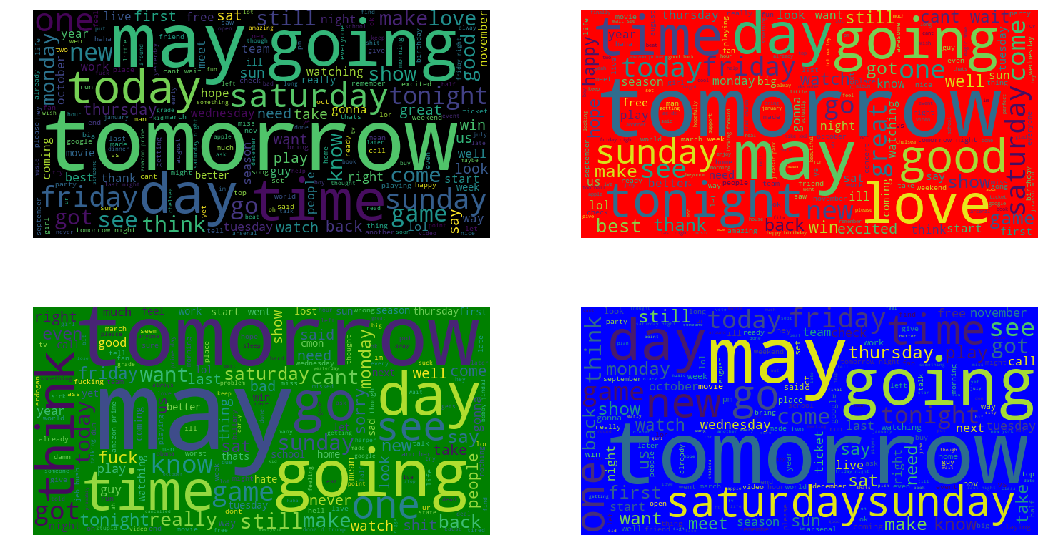

In [24]:
plt.figure(figsize=(18,10))

final = ""
for word in fusedTokens:
    final += " " + word
    
wc = WordCloud(background_color = "black", width = 640, height = 320).generate(final)

plt.subplot2grid((2,2),(0,0))
plt.imshow(wc)
plt.axis("off")
# plt.show()

# ----------------------------------------------------------#

final = ""
for word in positives:
    final += " " + word
    
wc = WordCloud(background_color = "red", width = 640, height = 320).generate(final)

plt.subplot2grid((2,2),(0,1))
plt.imshow(wc)
plt.axis("off")
# plt.show()

# ----------------------------------------------------------#

final = ""
for word in negatives:
    final += " " + word
    
wc = WordCloud(background_color = "green", width = 640, height = 320).generate(final)

plt.subplot2grid((2,2),(1,0))
plt.imshow(wc)
plt.axis("off")
# plt.show()

# ----------------------------------------------------------#

final = ""
for word in neutrals:
    final += " " + word
    
wc = WordCloud(background_color = "blue", width = 640, height = 320).generate(final)

plt.subplot2grid((2,2),(1,1))
plt.imshow(wc)
plt.axis("off")
plt.show()

Generally we can see that words like "love" appear in positive posts as expected , whereas "positive" words like "like" appear in negative posts . Also there are many neutral words like "tomorrow" that have the same distribution in both positive and negative posts.

In [25]:
newTokens = []
for item in tokens:
    final = ""
    for word in item:
        final += " " + word
#     print(final)
    newTokens.append(final)
    
# bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=100, stop_words='english')
bow_vectorizer = CountVectorizer(max_features=7000)
bow_xtrain = bow_vectorizer.fit_transform(newTokens)  #TWEETS : a list with the actual tweets 
# print(bow_vectorizer.get_feature_names())
# print(bow_xtrain.toarray())

# The output is a numpy array of features. The dimensionality of this array 
# depends on the number of TWEETS (shape should be number_of_tweets ∙ vocabulary_size) 
print(bow_xtrain.shape)

# filename = "bow.pkl"
outfile = open("bigbow.pkl" , "wb")
pickle.dump(bow_xtrain , outfile)
outfile.close()

(27958, 7000)


In [26]:
# print(bow_vectorizer.get_feature_names())

# for box in bow_xtrain.toarray():
#     print(box)

In [27]:
# tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english') 
tfidf_vectorizer = TfidfVectorizer(max_features=7000)
tfidf = tfidf_vectorizer.fit_transform(newTokens)
print(tfidf.shape) #the output is a numpy array of features


# filename = "tfidf.pkl"
outfile = open("bigtfidf.pkl" , "wb")
pickle.dump(tfidf , outfile)
outfile.close()

(27958, 7000)


In [28]:
# tokenized_tweet = tweets.apply(lambda x: x.split()) # tokenizing 

featuresSize = 300

model_w2v = gensim.models.Word2Vec(tokens,
                                   size      = featuresSize, # desired no. of features/independent variables
                                   window    = 5,  # context window size
                                   min_count = 2,
                                   sg        = 1,  # 1 for skip-gram model
                                   hs        = 0,
                                   negative  = 10, # for negative sampling
                                   workers   = 2,  # no.of cores
                                   seed      = 34) 

model_w2v.train(tokens, total_examples = len(tokens), epochs = 20)


(5218401, 5888380)

In [29]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model.wv.__getitem__(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity = 40, n_components = 2, init = 'pca', n_iter = 2500, random_state = 23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize = (16,16)) 
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy = (x[i], y[i]), xytext = (5,2), textcoords = 'offset points', ha = 'right', va = 'bottom')
        
    plt.show()

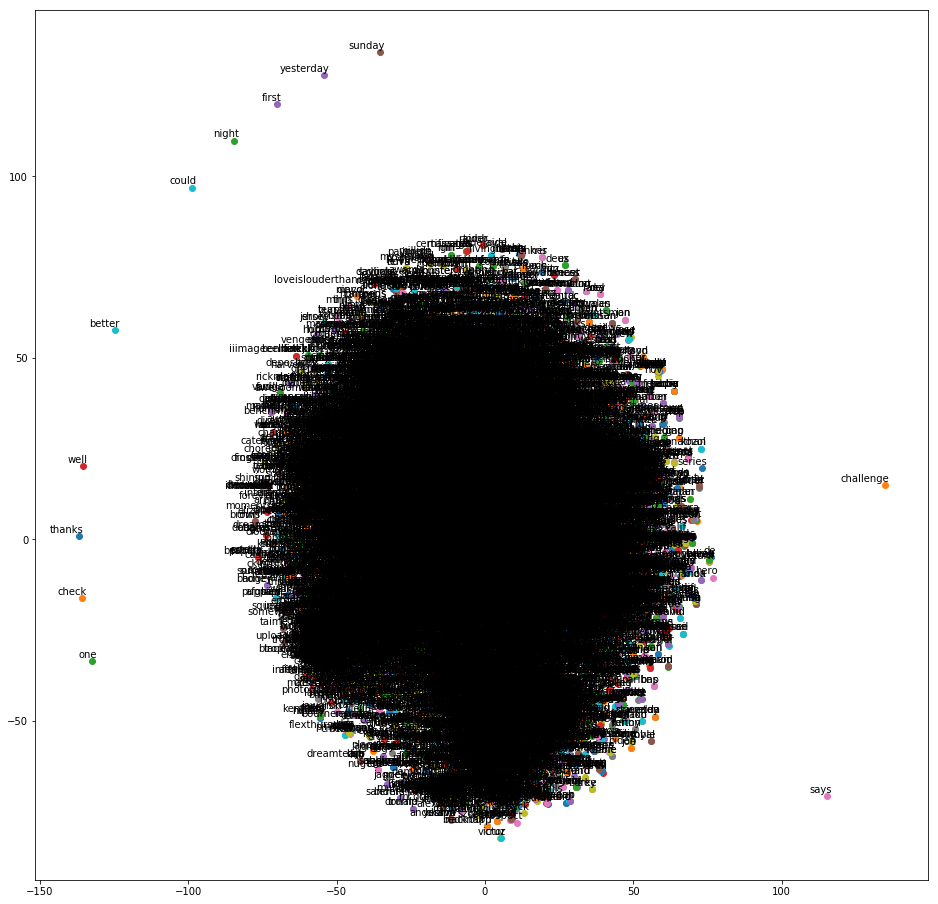

In [30]:
tsne_plot(model_w2v)

In [38]:
dictNum  = 1
allDicts = []

dictLocation = "./lexica/generic/generic.txt"
file = open(dictLocation, "r")
genericDict = {}
for line in file:
    temp  = []
    count = 1
    for word in line.split():
        if count == 1:
            temp.append(word)
        else:
            temp.append(float(word))
        count += 1
    genericDict[temp[0]] = temp[1]
    
allDicts.extend([genericDict])

In [32]:
# dictNum += 1

# dictLocation = "./lexica/emotweet/valence_tweet.txt"
# file = open(dictLocation, "r")
# vl_dic = []
# for line in file:
#     print(line)
#     temp = []
#     count = 1
#     for word in line.split():
#         print(word)
#         if count == 1:
#             temp.append(word)
#         else:
#             temp.append(float(word))
#         count += 1
#     vl_dic.extend([temp])
    
# allDicts.extend([vl_dic])

In [48]:
dictNum += 1

dictLocation = "./lexica/affin/affin.txt"
file = open(dictLocation, "r")
af_dic = {}

for line in file:
    temp = []
    split_phrase = []

    for word in line.split():
        split_phrase.append(word)
    
    tmp_str = ""
    for ph_word in split_phrase[:-1]:
        if tmp_str == "":
            tmp_str += ph_word
        else:
            tmp_str += " " + ph_word
    
    temp.append(tmp_str)
    temp.append(float(split_phrase[-1]))

#     af_dic.extend([temp])
    af_dic[temp[0]] = temp[1]
    
allDicts.extend([af_dic])

In [49]:
dictNum += 1

dictLocation = "./lexica/nrc/val.txt"
file = open(dictLocation, "r")
nrc_dic = {}

for line in file:
    temp = []
    split_phrase = []

    for word in line.split():
        split_phrase.append(word)
    
    tmp_str = ""
    for ph_word in split_phrase[:-1]:
        if tmp_str == "":
            tmp_str += ph_word
        else:
            tmp_str += " " + ph_word
    
    temp.append(tmp_str)
    temp.append(float(split_phrase[-1]))
    nrc_dic[temp[0]] = temp[1]
#     nrc_dic.extend([temp])
    
allDicts.extend([nrc_dic])

In [50]:
dictNum += 1

dictLocation = "./lexica/nrctag/val.txt"
file = open(dictLocation, "r")
nrctag_dic = {}

for line in file:
    temp = []
    split_phrase = []

    for word in line.split():
        split_phrase.append(word)
    
    tmp_str = ""
    for ph_word in split_phrase[:-1]:
        if tmp_str == "":
            tmp_str += ph_word
        else:
            tmp_str += " " + ph_word
    
    temp.append(tmp_str)
    temp.append(float(split_phrase[-1]))
    nrctag_dic[temp[0]] = temp[1]
#     nrctag_dic.extend([temp])
    
allDicts.extend([nrctag_dic])

In [51]:
word_vectors = model_w2v.wv
allTweetFeatsList = []

for sentence in tokens:
#     print("\n",sentence)
    
    tweetFeatures = []
    
    for i in range(0,featuresSize):
        value     = 0
        wordCount = 0
        
        for word in sentence:
            if word in word_vectors.vocab:
                wordCount += 1
                value     += word_vectors[word][i]
                
        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)
    
    for dic in allDicts:
#         print(dic)
        value     = 0
        wordCount = 0

        for word in sentence:
#             print(word)
            if word in dic:
                wordCount += 1
                value     += token[1]

        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)

# #         print(tweetFeatures , "\n")
    
            
    allTweetFeatsList.extend([tweetFeatures])

# print(allTweetFeatsList)

# filename = "wordEmbs.pkl"
outfile = open("bigwordEmbs.pkl" , "wb")
pickle.dump(allTweetFeatsList , outfile)
outfile.close()

In [52]:
infile = open("bigbow.pkl" , "rb")
bow_xtrain = pickle.load(infile)
infile.close()

# input for this method is any array of features
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(bow_xtrain, emotions, random_state = 42, test_size = 0.2)

In [53]:
svcBow = svm.SVC(kernel = 'linear', C = 1, probability = True)

# xtrain_bow: bag of words features for train data
# ytrain: train data labels
svcBow = svcBow.fit(xtrain_bow, ytrain)

# probPrediction = svcBow.predict_proba(xvalid_bow) #predict on the validation set
prediction_int = svcBow.predict(xvalid_bow)
prediction_int = prediction_int.tolist()

# evaluate on the validation set
tmp_svm_bow_score = f1_score(yvalid, prediction_int, average = "micro")

In [54]:
outfile = open("predbow.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [55]:
infile = open("bigtfidf.pkl" , "rb")
tfidf = pickle.load(infile)
infile.close()

# input for this method is any array of features
xtrain, xvalid, ytrain, yvalid = train_test_split(tfidf , emotions, random_state = 42, test_size = 0.2)

In [56]:
svcIdf = svm.SVC(kernel = 'linear', C = 1, probability = True)

# xtrain: tfidf features for train data
# ytrain: train data labels
svcIdf = svcIdf.fit(xtrain, ytrain) 

# probPrediction = svcIdf.predict_proba(xvalid) #predict on the validation set
prediction_int = svcIdf.predict(xvalid)
prediction_int = prediction_int.tolist()

# evaluate on the validation set
tmp_svm_tdidf_score = f1_score(yvalid, prediction_int, average = "micro")

In [57]:
outfile = open("predtfidf.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [58]:
infile = open("bigwordEmbs.pkl" , "rb")
allTweetFeatsList = pickle.load(infile)
infile.close()

# input for this method is any array of features
xtrain, xvalid, ytrain, yvalid = train_test_split(allTweetFeatsList , emotions, random_state = 42, test_size = 0.2)

In [59]:
svcW2V = svm.SVC(kernel = 'linear', C = 1, probability = True)

# xtrain: word2vec features for train data
# ytrain: train data labels
svcW2V = svcW2V.fit(xtrain, ytrain)

# probPrediction = svcW2V.predict_proba(xvalid) #predict on the validation set
prediction_int = svcW2V.predict(xvalid)
prediction_int = prediction_int.tolist()

# evaluate on the validation set
tmp_svm_w2v_score = f1_score(yvalid, prediction_int , average = "micro")

In [60]:
outfile = open("predwordEmbs.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

Doing the same with test data :

In [67]:
location = './twitter_data/test2017.tsv'
df = pd.read_csv(location , sep = "\t" , header = None)
emoLocation = './twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt'
emoFile = open(emoLocation, "r")
testEmotions = []
for line in emoFile:
    temp  = []
    count = 1
    for word in line.split():
        if count == 2:
            temp.append(word)
        count += 1
    testEmotions.extend(temp)

In [68]:
# ndf = df.head(10) #takes the first x entries

# dl = ndf.values.tolist()

dl = df.values.tolist()

tokens      = []
fusedTokens = []
tknzr       = TweetTokenizer(preserve_case = False, 
                             strip_handles = True, 
                             reduce_len    = True)
for item in dl:
    tweet = item[3]
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*' , '' , tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+' , '' , tweet)
 
    # remove hyperlinks
    tweet = re.sub(r"http\S+", "", tweet)
    
    # remove hashtags, removing the hash (#) sign only from the word
    tweet = re.sub(r'#' , '' , tweet)
    
    temp = tknzr.tokenize(tweet)
    
    stop_words = stopwords.words('english')    #sets stop words
    newStopWords = ["i'm" , "he's" , "she's" , "it's" , "we're" , "you're" , "they're" , "via"]
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    
    temp = [w for w in temp if not w in stop_words]  #removes stop words

    table = str.maketrans('', '', string.punctuation) #remove punctuation
    temp = [w.translate(table) for w in temp]
#     print("TEMP 3 = ",temp)
    temp = [word for word in temp if word.isalpha()] #remove remaining tokens that are not alphabetic

#     porter = PorterStemmer() #stemming (not that useful)
#     temp = [porter.stem(word) for word in temp]

    
    fusedTokens.extend(temp)
    tokens.append(temp)

In [69]:
newTokens = []
for item in tokens:
    final = ""
    for word in item:
        final += " " + word
    newTokens.append(final)
    
bow_xtest = bow_vectorizer.transform(newTokens)  #TWEETS : a list with the actual tweets 

# The output is a numpy array of features. The dimensionality of this array 
# depends on the number of TWEETS (shape should be number_of_tweets ∙ vocabulary_size) 
print(bow_xtest.shape)

outfile = open("testbow.pkl" , "wb")
pickle.dump(bow_xtest , outfile)
outfile.close()

(12284, 7000)


In [70]:
tfidf = tfidf_vectorizer.transform(newTokens)
print(tfidf.shape) #the output is a numpy array of features


outfile = open("testtfidf.pkl" , "wb")
pickle.dump(tfidf , outfile)
outfile.close()

(12284, 7000)


In [72]:
featuresSize = 300

model_w2v = gensim.models.Word2Vec(tokens,
                                   size      = featuresSize, # desired no. of features/independent variables
                                   window    = 5,  # context window size
                                   min_count = 2,
                                   sg        = 1,  # 1 for skip-gram model
                                   hs        = 0,
                                   negative  = 10, # for negative sampling
                                   workers   = 2,  # no.of cores
                                   seed      = 34) 

model_w2v.train(tokens, total_examples = len(tokens), epochs = 20)

(1901629, 2151820)

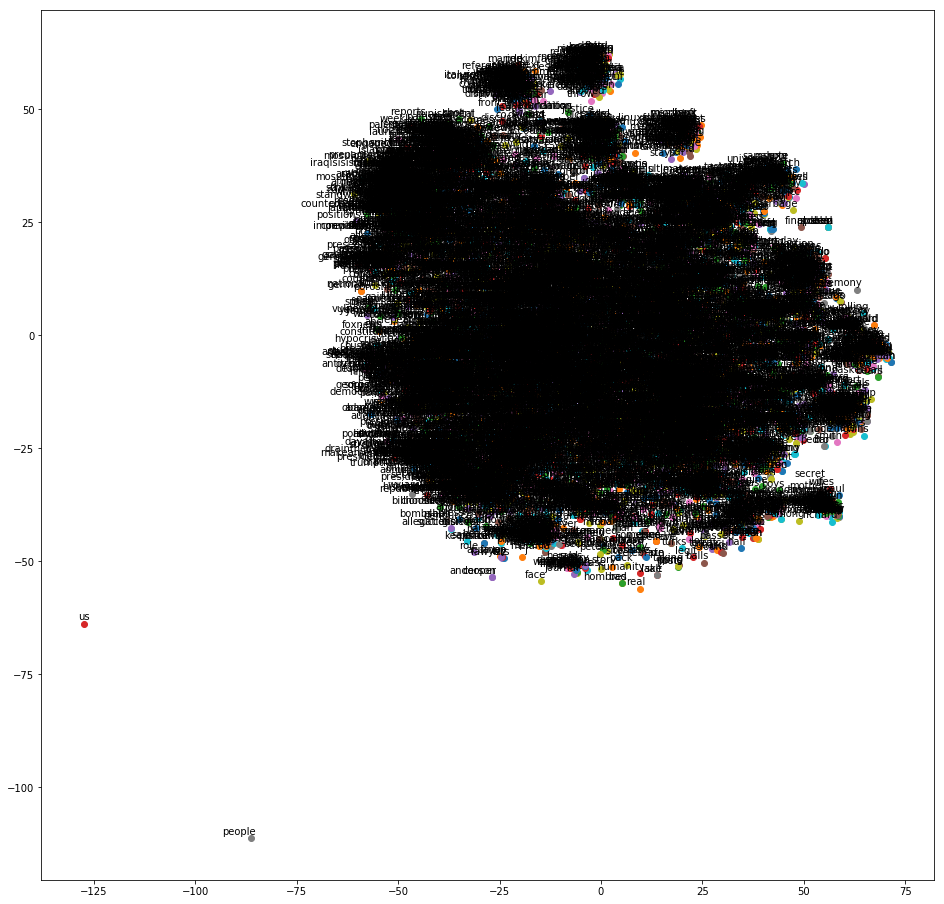

In [73]:
tsne_plot(model_w2v)

In [99]:
word_vectors = model_w2v.wv
allTweetFeatsList = []
allTweetNoDict = []

for sentence in tokens:
#     print("\n",sentence)
    
    tweetFeatures = []
    
    for i in range(0,featuresSize):
        value     = 0
        wordCount = 0
        
        for word in sentence:
            if word in word_vectors.vocab:
                wordCount += 1
                value     += word_vectors[word][i]
                
        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)
    
    allTweetNoDict.extend([tweetFeatures])
    
    for dic in allDicts:
#         print(dic)
        value     = 0
        wordCount = 0

        for word in sentence:
#             print(word)
            if word in dic:
                wordCount += 1
                value     += token[1]

        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)

# #         print(tweetFeatures , "\n")
    
            
    allTweetFeatsList.extend([tweetFeatures])

# filename = "wordEmbs.pkl"
outfile = open("testwordEmbs.pkl" , "wb")
pickle.dump(allTweetFeatsList , outfile)
outfile.close()

outfile = open("testwordEmbsNoDict.pkl" , "wb")
pickle.dump(allTweetNoDict , outfile)
outfile.close()

In [75]:
infile = open("testbow.pkl" , "rb")
bow_xtest = pickle.load(infile)
infile.close()

In [76]:
# probPrediction = svcBow.predict_proba(bow_xtrain) #predict on the validation set
prediction_int = svcBow.predict(bow_xtest)
prediction_int = prediction_int.tolist()
svm_bow_score = f1_score(testEmotions, prediction_int , average="micro") #evaluate on the validation set

In [77]:
outfile = open("predtestbow.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [78]:
infile = open("testtfidf.pkl" , "rb")
tfidf = pickle.load(infile)
infile.close()

In [79]:
# probPrediction = svcIdf.predict_proba(tfidf) #predict on the validation set
prediction_int = svcIdf.predict(tfidf)
prediction_int = prediction_int.tolist()

svm_tdidf_score = f1_score(testEmotions, prediction_int , average="micro") #evaluate on the validation set

In [80]:
outfile = open("predtesttfidf.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [81]:
infile = open("testwordEmbs.pkl" , "rb")
allTweetFeatsList = pickle.load(infile)
infile.close()

In [82]:
# probPrediction = svcW2V.predict_proba(allTweetFeatsList) #predict on the validation set
prediction_int = svcW2V.predict(allTweetFeatsList)
prediction_int = prediction_int.tolist()

svm_w2v_score = f1_score(testEmotions, prediction_int , average="micro") #evaluate on the validation set

In [83]:
outfile = open("predtestwordEmbs.pkl" , "wb")
pickle.dump(prediction_int , outfile)
outfile.close()

In [84]:
infile = open("bigbow.pkl" , "rb")
bow_xtrain = pickle.load(infile)
infile.close()

In [85]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(bow_xtrain , emotions)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [86]:
infile = open("testbow.pkl" , "rb")
bow_xtest = pickle.load(infile)
infile.close()

In [87]:
prediction_knn = knn.predict(bow_xtest)
knn_bow_score = f1_score(testEmotions, prediction_knn , average="micro") #evaluate on the validation set

In [88]:
infile = open("bigtfidf.pkl" , "rb")
tfidf = pickle.load(infile)
infile.close()

In [89]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(tfidf , emotions)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [90]:
infile = open("testtfidf.pkl" , "rb")
tfidf_new = pickle.load(infile)
infile.close()

In [91]:
prediction_knn = knn.predict(tfidf_new)
knn_tdidf_score = f1_score(testEmotions, prediction_knn , average="micro") #evaluate on the validation set

In [92]:
infile = open("bigwordEmbs.pkl" , "rb")
w2v = pickle.load(infile)
infile.close()

In [93]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(w2v , emotions)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [94]:
infile = open("testwordEmbs.pkl" , "rb")
w2v_new = pickle.load(infile)
infile.close()

In [95]:
prediction_knn = knn.predict(w2v_new)
knn_w2v_score = f1_score(testEmotions, prediction_knn , average="micro") #evaluate on the validation set

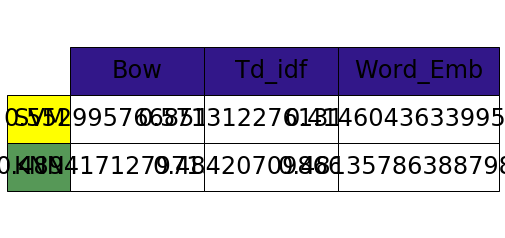

In [96]:
fig = plt.figure()
ax  = fig.add_subplot(111)

col_labels = ['Bow', 'Td_idf', 'Word_Emb']
row_labels = ['SVM', 'KNN']
table_vals = [[svm_bow_score, svm_tdidf_score, svm_w2v_score], [knn_bow_score, knn_tdidf_score, knn_w2v_score]]

# Draw table
the_table = plt.table(cellText  = table_vals,
                      colWidths = [0.1, 0.1, 0.12],
                      rowLabels = row_labels,
                      colLabels = col_labels,
                      loc       = 'center'  ,
                      cellLoc   = 'center',
                      rowColours=('Yellow','#569857'),
                      colColours=("#321789","#321789","#321789"))

the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)